# Import necessary libraries

In [ ]:
!pip install ucimlrepo
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import torch
import matplotlib.pyplot as plt
import category_encoders as ce
import random

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from ucimlrepo import fetch_ucirepo
from functools import reduce
from torch import nn # should this be the nn for the dndt

%matplotlib inline
tf1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Compare results of DNDT to NN and DT

## Define Deep Neural Decision Tree Functions
Provided by paper being reproduced.

In [ ]:
def tf_kron_prod(a, b):
    res = tf.einsum('ij,ik->ijk', a, b)
    res = tf.reshape(res, [-1, tf.reduce_prod(res.shape[1:])])
    return res


def tf_bin(x, cut_points, temperature=0.1):
    # x is a N-by-1 matrix (column vector)
    # cut_points is a D-dim vector (D is the number of cut-points)
    # this function produces a N-by-(D+1) matrix, each row has only one element being one and the rest are all zeros
    D = cut_points.get_shape().as_list()[0]
    W = tf.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1])
    cut_points = tf.sort(cut_points)  # make sure cut_points is monotonically increasing
    b = tf.cumsum(tf.concat([tf.constant(0.0, shape=[1]), -cut_points], 0))
    h = tf.matmul(x, W) + b
    res = tf.nn.softmax(h / temperature)
    return res


def nn_decision_tree(x, cut_points_list, leaf_score, temperature=0.1):
    # cut_points_list contains the cut_points for each dimension of feature
    leaf = reduce(tf_kron_prod,
                  map(lambda z: tf_bin(x[:, z[0]:z[0] + 1], z[1], temperature), enumerate(cut_points_list)))
    return tf.matmul(leaf, leaf_score)

##Dataset 1: Haberman's Dataset

Load data, extract features and labels, then split into train and test sets.

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
data = pd.read_csv(url, header=None)

# Optionally, add column names for readability
data.columns = ['Age', 'Year', 'Nodes', 'Survival_Status']
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Decision Tree
Target to reproduce: 66.1%.

In [ ]:
# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=26)
dt_model.fit(X_train, y_train)

# Evaluate the model
dt_predictions = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, dt_predictions)
dt_habermans = round(accuracy*100, 1)

print("Haberman's Survival Decision Tree Accuracy:")
print("  Target:  ", 66.1)
print("  Achieved:", dt_habermans)

Haberman's Survival Decision Tree Accuracy:
  Target:   66.1
  Achieved: 66.1


### Neural Network
Target to reproduce: 70.9%.

In [ ]:
def create_nn_model(input_shape):
    model = Sequential([
        Dense(50, activation='relu', input_shape=input_shape),
        Dense(50, activation='relu'),
        Dense(1, activation='softmax')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Preparing the data
input_shape = (X_train.shape[1],)
nn_model_tf = create_nn_model(input_shape)

# Training the model
nn_model_tf.fit(X_train, y_train, epochs=1000, batch_size=10, verbose=0)

# Evaluating the model
nn_predictions_tf = nn_model_tf.predict(X_test)
nn_predictions_tf = [1 if pred > 0.5 else 0 for pred in nn_predictions_tf]
accuracy = accuracy_score(y_test, nn_predictions_tf)
nn_habermans = round(accuracy*100, 1)

print("Haberman's Survival Neural Network Accuracy:")
print("  Target:  ", 70.9)
print("  Achieved:", nn_habermans)

Haberman's Survival Neural Network Accuracy:
  Target:   70.9
  Achieved: 71.0


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


### Deep Neural Decision Tree
Target to reproduce: 70.9%.

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
columns = ['Age', 'Year', 'Nodes', 'SurvivalStatus']
data = pd.read_csv(url, header=None, names=columns)

# The 'SurvivalStatus' column is '1' for patients who survived 5 years or longer and '2' for those who didn't.
# Convert this to a binary classification problem: '0' for 'did not survive' and '1' for 'survived'
data['SurvivalStatus'] = data['SurvivalStatus'].map({1: 0, 2: 1})

# Separate features and target variable
X = data.drop('SurvivalStatus', axis=1).values
y = data['SurvivalStatus'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))


np.random.seed(1943)
tf1.set_random_seed(1943)

d = X_scaled.shape[1]  # Number of features
num_cut = [1, 1, 1]    # Number of cut points for each feature
num_leaf = np.prod(np.array(num_cut) + 1)
num_class = 2          # Binary classification

sess = tf1.InteractiveSession()

x_ph = tf1.placeholder(tf1.float32, [None, d])
y_ph = tf1.placeholder(tf1.float32, [None, num_class])

cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_class]))

y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)
loss = tf1.reduce_mean(tf1.losses.softmax_cross_entropy(logits=y_pred, onehot_labels=y_ph))
opt = tf1.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

sess.run(tf1.global_variables_initializer())

for i in range(1000):
    _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_scaled, y_ph: y_one_hot})
    if i % 100 == 0 and False:
        print("Loss at step {}: {}".format(i, loss_val))

accuracy = np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: X_scaled}), axis=1) == np.argmax(y_one_hot, axis=1))
dndt_habermans = round(accuracy*100, 1)

print("Haberman's Survival Deep Neural Decision Tree Accuracy:")
print("  Target:  ", 70.9)
print("  Achieved:", dndt_habermans)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Haberman's Survival Deep Neural Decision Tree Accuracy:
  Target:   70.9
  Achieved: 78.1


###Compare results from all models

In [ ]:
print("                    ", "DNDT", " DT ", " NN")
print("Target Accuracies:  ", 70.9, 66.1, 70.9)
print("Achieved Accuracies:", dndt_habermans, dt_habermans, nn_habermans)

                     DNDT  DT   NN
Target Accuracies:   70.9 66.1 70.9
Achieved Accuracies: 78.1 66.1 71.0


### Analysis Haberman's Active Cut Points

In [ ]:
#Test Code here
@tf.function
def tf_kron_prod(a, b):
    res = tf.einsum('ij,ik->ijk', a, b)
    res = tf.reshape(res, [-1, tf.reduce_prod(res.shape[1:])])
    return res

@tf.function
def tf_bin(x, cut_points, temperature=0.1):
    D = cut_points.get_shape().as_list()[0]
    W = tf.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1])
    cut_points = tf.sort(cut_points)
    b = tf.cumsum(tf.concat([tf.constant(0.0, shape=[1]), -cut_points], 0))
    h = tf.matmul(x, W) + b
    res = tf.nn.softmax(h / temperature)
    return res

@tf.function
def active_cut_points(x, cut_points_list, temperature=0.1):
    active_points = []

    for i, cut_points in enumerate(cut_points_list):
        bin_result = tf_bin(x[:, i:i+1], cut_points, temperature)

        # Check if at least one instance falls on each side of the cut point
        left_count = tf.reduce_sum(tf.cast(tf.math.greater(bin_result[:, :-1], 0.5), tf.float32))
        right_count = tf.reduce_sum(tf.cast(tf.math.greater(bin_result[:, 1:], 0.5), tf.float32))

        # Use tf.reduce_all to operate within the TensorFlow graph
        is_active = tf.reduce_all([left_count > 0, right_count > 0])

        if is_active:
            active_points.append((i, cut_points))

    return active_points

@tf.function
def nn_decision_tree(x, cut_points_list, leaf_score, temperature=0.1):
    active_points = active_cut_points(x, cut_points_list, temperature)

    # # Print or use active_points as needed
    # print("Active Cut Points:", active_points)

    leaf = reduce(tf_kron_prod,
                  map(lambda z: tf_bin(x[:, z[0]:z[0] + 1], z[1], temperature), active_points))
    return tf.matmul(leaf, leaf_score)

# Load and preprocess the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
columns = ['Age', 'Year', 'Nodes', 'SurvivalStatus']
data = pd.read_csv(url, header=None, names=columns)

# The 'SurvivalStatus' column is '1' for patients who survived 5 years or longer and '2' for those who didn't.
# Convert this to a binary classification problem: '0' for 'did not survive' and '1' for 'survived'
data['SurvivalStatus'] = data['SurvivalStatus'].map({1: 0, 2: 1})

# Separate features and target variable
X = data.drop('SurvivalStatus', axis=1).values
y = data['SurvivalStatus'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

np.random.seed(1943)
tf.random.set_seed(1943)

perc_active_cut_list = []
num_cut_list = [[1,1,1],[2,2,2],[3,3,3], [4,4,4], [5,5,5]]

for num_cut in num_cut_list:
  d = X_scaled.shape[1]  # Number of features
  num_cut = num_cut    # Number of cut points for each feature
  num_leaf = np.prod(np.array(num_cut) + 1)
  num_class = 2          # Binary classification

  # Create TensorFlow session
  sess = tf.compat.v1.InteractiveSession()

  # Define placeholders and variables
  x_ph = tf.compat.v1.placeholder(tf.float32, [None, d])
  y_ph = tf.compat.v1.placeholder(tf.float32, [None, num_class])

  cut_points_list = [tf.compat.v1.Variable(tf.random.uniform([i])) for i in num_cut]
  leaf_score = tf.compat.v1.Variable(tf.random.uniform([num_leaf, num_class]))

  # Define the neural decision tree model
  y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)

  # Define loss and optimizer
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_ph))
  opt = tf.compat.v1.train.AdamOptimizer(0.1)
  train_step = opt.minimize(loss)

  # Initialize variables
  sess.run(tf.compat.v1.global_variables_initializer())

  # Training loop
  for i in range(1000):
      _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_scaled, y_ph: y_one_hot})
      #if i % 100 == 0:
          #print("Loss at step {}: {}".format(i, loss_val))

  # Evaluate the percentage of active cut points
  percentage_active_cut_points = sess.run(active_cut_points(x_ph, cut_points_list, temperature=0.1), feed_dict={x_ph: X_scaled})
  total_cut_points = X_scaled.shape[1] * sum(num_cut)
  percentage_active_cut_points = len(percentage_active_cut_points) / total_cut_points * 100

  #Appending the cut_points to the list
  perc_active_cut_list.append(round(percentage_active_cut_points, 2))

  print(f"Percentage of Active Cut Points: {percentage_active_cut_points:.2f}%")
  sess.close
perc_active_cut_list

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Percentage of Active Cut Points: 33.33%
Percentage of Active Cut Points: 16.67%
Percentage of Active Cut Points: 11.11%
Percentage of Active Cut Points: 8.33%
Percentage of Active Cut Points: 6.67%


[33.33, 16.67, 11.11, 8.33, 6.67]

####Graph plot for Number of active cut points

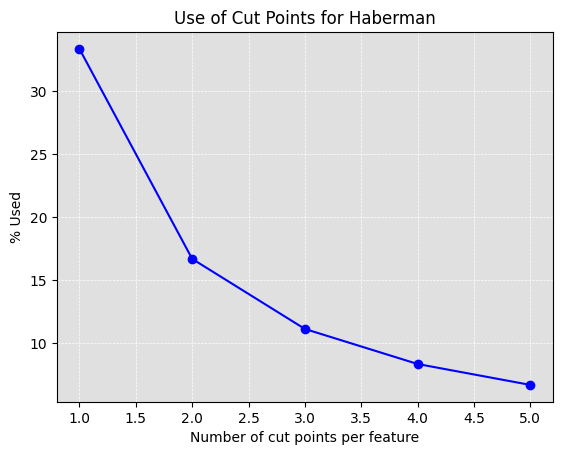

In [ ]:
import matplotlib.pyplot as plt
# Create x values from 1 to the number of elements in the list
x_values = list(range(1, len(perc_active_cut_list) + 1))

# Plotting the line graph
plt.plot(x_values,perc_active_cut_list, marker='o', linestyle='-', color='blue')

# Adding labels and title
plt.xlabel('Number of cut points per feature')
plt.ylabel('% Used')
plt.title('Use of Cut Points for Haberman')

# Set background color and grid style
plt.gca().set_facecolor('#E0E0E0')  # Light gray background
plt.grid(color='white', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

##Dataset 2: Titanic Dataset

Load data, extract features and labels, then split into train and test sets.

In [ ]:
# Load the Titanic dataset
titanic_url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
titanic_data = pd.read_csv(titanic_url)

# Preprocessing steps
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 0, 'female': 1})
titanic_data = titanic_data[['Survived', 'Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']]

# Define features and target variable
X_titanic = titanic_data.iloc[:, 1:].values
y_titanic = titanic_data.iloc[:, 0].values

# Split the dataset
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=42) # was 26

# Scale the features
scaler_titanic = StandardScaler()
X_train_titanic = scaler_titanic.fit_transform(X_train_titanic)
X_test_titanic = scaler_titanic.transform(X_test_titanic)

### Decision Tree
Target to reproduce: 79.0%.

In [ ]:
# Create and train the Decision Tree model
dt_model_titanic = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=26)
dt_model_titanic.fit(X_train_titanic, y_train_titanic)

# Evaluate the model
dt_predictions_titanic = dt_model_titanic.predict(X_test_titanic)
accuracy = accuracy_score(y_test_titanic, dt_predictions_titanic)
dt_titanic = round(accuracy*100, 1)

print("Titanic Decision Tree Accuracy:")
print("  Target:  ", 79.0)
print("  Achieved:", dt_titanic)

Titanic Decision Tree Accuracy:
  Target:   79.0
  Achieved: 72.5


### Neural Network
Target to reproduce: 76.9%.

In [ ]:
# Create tf neural network model
def create_nn_model_titanic(input_shape):
    model = Sequential([
        Dense(50, activation='relu', input_shape=input_shape),
        Dense(50, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Preparing the data
input_shape_titanic = (X_train_titanic.shape[1],)
nn_model_tf_titanic = create_nn_model_titanic(input_shape_titanic)

# Training the model
nn_model_tf_titanic.fit(X_train_titanic, y_train_titanic, epochs=100, batch_size=32, verbose=0)

# Evaluating the model
nn_predictions_tf_titanic = nn_model_tf_titanic.predict(X_test_titanic)
nn_predictions_tf_titanic = [1 if pred > 0.5 else 0 for pred in nn_predictions_tf_titanic]
accuracy = accuracy_score(y_test_titanic, nn_predictions_tf_titanic)
nn_titanic = round(accuracy*100, 1)

print("Titanic Neural Network Accuracy:")
print("  Target:  ", 76.9)
print("  Achieved:", nn_titanic)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Titanic Neural Network Accuracy:
  Target:   76.9
  Achieved: 77.5


###Deep Neural Decision Tree
Target to reproduce: 80.4%.

In [ ]:
# Define the TensorFlow graph and session
sess = tf1.InteractiveSession()

# Load the Titanic dataset (assuming you have it as a CSV file)
titanic_url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
titanic_data = pd.read_csv(titanic_url)

# Check if 'Ticket' and 'Cabin' columns exist before dropping them
columns_to_drop = ['Name']
if 'Ticket' in titanic_data.columns:
    columns_to_drop.append('Ticket')
if 'Cabin' in titanic_data.columns:
    columns_to_drop.append('Cabin')

# Drop the specified columns
titanic_data = titanic_data.drop(columns_to_drop, axis=1)

# Handle missing values (you can choose a different strategy if needed)
titanic_data = titanic_data.dropna()

# Convert categorical columns (e.g., 'Sex', 'Embarked') to one-hot encoding
titanic_data = pd.get_dummies(titanic_data, columns=['Sex'], drop_first=True)

# Separate features and target variable
X = titanic_data.drop('Survived', axis=1).values
y = titanic_data['Survived'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Set random seeds for reproducibility
np.random.seed(1943)
tf1.set_random_seed(1943)

# Define placeholders for input and output
num_features = X_train.shape[1]
x_ph = tf1.placeholder(tf1.float32, [None, num_features])
y_ph = tf1.placeholder(tf1.float32, [None])

# Define DNDT hyperparameters
num_cut = [1] * num_features  # Adjust as needed
num_classes = 2  # Binary classification

# Define variables for cut points and leaf scores
cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]

# Calculate the number of leaf nodes based on the number of cut points
num_leaf = np.prod(np.array(num_cut) + 1)

# Define the shape of leaf_score based on the number of classes and leaf nodes
leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_classes]))

# Build the DNDT model
y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)


# Define loss and optimizer
loss = tf1.reduce_mean(tf1.losses.sparse_softmax_cross_entropy(labels=tf1.cast(y_ph, dtype=tf1.int32), logits=y_pred))
opt = tf1.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

# Initialize variables
sess.run(tf1.global_variables_initializer())

# Train the model
for i in range(1000):
    _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_train, y_ph: y_train})
    if i % 100 == 0 and False:
        print("Loss at step {}: {:.4f}".format(i, loss_val))

# Evaluate the model
accuracy = tf1.reduce_mean(tf1.cast(tf1.equal(tf1.argmax(y_pred, 1), tf1.cast(y_ph, dtype=tf1.int64)), tf1.float32))
test_accuracy = sess.run(accuracy, feed_dict={x_ph: X_test, y_ph: y_test})
dndt_titanic = round(test_accuracy*100, 1)

print("Titanic Deep Neural Decision Tree Accuracy:")
print("  Target:  ", 80.4)
print("  Achieved:", dndt_titanic)

sess.close() # close InteractiveSession

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Titanic Deep Neural Decision Tree Accuracy:
  Target:   80.4
  Achieved: 75.8


###Compare results from all models

In [ ]:
print("                    ", "DNDT", " DT ", " NN")
print("Target Accuracies:  ", 80.4, 79.0, 76.9)
print("Achieved Accuracies:", dndt_titanic, dt_titanic, nn_titanic)

                     DNDT  DT   NN
Target Accuracies:   80.4 79.0 76.9
Achieved Accuracies: 75.8 72.5 77.5


## Dataset 3: Pima Dataset

Load data, extract features and labels, then split into train and test sets.

In [ ]:
# Load the dataset from a public URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Separating features and target variable
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###Decision Tree
Target to reproduce: 74.7%.

In [ ]:
# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate the model
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_pima = round(dt_accuracy*100, 1)

print("Pima Decision Tree Accuracy:")
print("  Target:  ", 74.7)
print("  Achieved:", dt_pima)

Pima Decision Tree Accuracy:
  Target:   74.7
  Achieved: 74.7


###Neural Network
Target to reproduce: 64.9%.

In [ ]:
# Create a TensorFlow neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
nn_pima = round(accuracy*100, 1)

print("Pima Neural Network Accuracy:")
print("  Target:  ", 64.9)
print("  Achieved:", nn_pima)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Pima Neural Network Accuracy:
  Target:   64.9
  Achieved: 74.0


###Deep Neural Decision Tree
Target to reproduce: 66.9%.

In [ ]:
def nn_decision_tree(x, cut_points_list, leaf_score, temperature=0.1):
    # Ensure x is a 2D tensor
    if len(x.get_shape()) != 2:
        raise ValueError("Input x must be a 2D tensor")

    # Process each feature
    leaf = reduce(tf_kron_prod,
                  map(lambda z: tf_bin(tf1.reshape(x[:, z[0]:z[0] + 1], [-1, 1]), z[1], temperature),
                      enumerate(cut_points_list)))
    return tf1.matmul(leaf, leaf_score)

sess = tf1.InteractiveSession()

# Load the Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
pima_data = pd.read_csv(url, names=column_names)

# Separate features and target variable
X = pima_data.drop('Outcome', axis=1).values  # Assuming 'Outcome' is the target column
y = pima_data['Outcome'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Set random seeds for reproducibility
np.random.seed(1943)
tf1.set_random_seed(1943)

# Define placeholders for input and output
num_features = X_train.shape[1]
x_ph = tf1.placeholder(tf1.float32, [None, num_features])
y_ph = tf1.placeholder(tf1.float32, [None])

# Define DNDT hyperparameters
num_cut = [1] * num_features  # Adjust as needed
num_classes = 2  # Binary classification

# Define variables for cut points and leaf scores
cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
num_leaf = np.prod(np.array(num_cut) + 1)
leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_classes]))

# Build the DNDT model (use the nn_decision_tree function from your original code)
y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)

# Define loss and optimizer
loss = tf1.reduce_mean(tf1.losses.sparse_softmax_cross_entropy(labels=tf1.cast(y_ph, dtype=tf1.int32), logits=y_pred))
opt = tf1.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

# Initialize variables
sess.run(tf1.global_variables_initializer())

# Train the model
for i in range(1000):
    _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_train, y_ph: y_train})
    if i % 100 == 0 and False:
        print("Loss at step {}: {:.4f}".format(i, loss_val))

# Evaluate the model
accuracy = tf1.reduce_mean(tf1.cast(tf1.equal(tf1.argmax(y_pred, 1), tf1.cast(y_ph, dtype=tf1.int64)), tf1.float32))
test_accuracy = sess.run(accuracy, feed_dict={x_ph: X_test, y_ph: y_test})
dndt_pima = round(test_accuracy*100, 1)

print("Pima Deep Neural Decision Tree Accuracy:")
print("  Target:  ", 66.9)
print("  Achieved:", dndt_pima)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Pima Deep Neural Decision Tree Accuracy:
  Target:   66.9
  Achieved: 65.6


###Compare results from all models

In [ ]:
print("                    ", "DNDT", " DT ", " NN")
print("Target Accuracies:  ", 66.9, 74.7, 64.9)
print("Achieved Accuracies:", dndt_pima, dt_pima, nn_pima)

                     DNDT  DT   NN
Target Accuracies:   66.9 74.7 64.9
Achieved Accuracies: 65.6 74.7 74.0


##Dataset 4: Iris Dataset

Load data, extract features and labels, then split into train and test sets.

In [ ]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###Decision Tree
Target to reproduce: 100.0%.

In [ ]:
# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate the model
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_iris = round(dt_accuracy*100, 1)

print("Iris Decision Tree Accuracy:")
print("  Target:  ", 100.0)
print("  Achieved:", dt_iris)

Iris Decision Tree Accuracy:
  Target:   100.0
  Achieved: 100.0


###Neural Network
Target to reproduce: 100.0%.

In [ ]:
# Neural Network Model using TensorFlow
def create_nn_model(input_shape, num_classes):
    model = Sequential([
        Dense(50, activation='relu', input_shape=input_shape),
        Dense(50, activation='relu'),
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Preparing the data
input_shape = (X_train.shape[1],)
num_classes = 3  # There are 3 species of Iris in the dataset
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

nn_model_tf = create_nn_model(input_shape, num_classes)

# Training the model
nn_model_tf.fit(X_train, y_train_encoded, epochs=100, batch_size=10, verbose=0)

# Evaluating the model
nn_predictions_tf = nn_model_tf.predict(X_test)
nn_predictions_tf = [np.argmax(pred) for pred in nn_predictions_tf]
nn_accuracy_tf = accuracy_score(y_test, nn_predictions_tf)
nn_iris = round(nn_accuracy_tf*100, 1)

print("Iris Neural Network Accuracy:")
print("  Target:  ", 100.0)
print("  Achieved:", nn_iris)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Iris Neural Network Accuracy:
  Target:   100.0
  Achieved: 100.0


###Deep Neural Decision Tree
Target to reproduce: 100.0%.

In [ ]:
sess = tf1.InteractiveSession()

# Load the Iris dataset
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris_data = pd.read_csv(iris_url, names=iris_columns)

# Encode the 'species' column to integers
label_encoder = LabelEncoder()
iris_data['species'] = label_encoder.fit_transform(iris_data['species'])

# Separate features and target variable
X = iris_data.drop('species', axis=1).values
y = iris_data['species'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Set random seeds for reproducibility
np.random.seed(1943)
tf1.set_random_seed(1943)

# Define placeholders for input and output
num_features = X_train.shape[1]
x_ph = tf1.placeholder(tf1.float32, [None, num_features])
y_ph = tf1.placeholder(tf1.int32, [None])

# Define DNDT hyperparameters
num_cut = [1] * num_features  # Adjust as needed
num_classes = 3  # There are three classes in the Iris dataset

# Define variables for cut points and leaf scores
cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
num_leaf = np.prod(np.array(num_cut) + 1)
leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_classes]))

# Build the DNDT model (use the nn_decision_tree function from your original code)
y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)

# Define loss and optimizer
loss = tf1.reduce_mean(tf1.losses.sparse_softmax_cross_entropy(labels=y_ph, logits=y_pred))
opt = tf1.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

# Initialize variables
sess.run(tf1.global_variables_initializer())

# Train the model
for i in range(1000):
    _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_train, y_ph: y_train})
    if i % 100 == 0 and False:
        print("Loss at step {}: {:.4f}".format(i, loss_val))

# Evaluate the model
accuracy = tf1.reduce_mean(tf1.cast(tf1.equal(tf1.argmax(y_pred, 1), tf1.cast(y_ph, tf1.int64)), tf1.float32))
test_accuracy = sess.run(accuracy, feed_dict={x_ph: X_test, y_ph: y_test})
dndt_iris = round(test_accuracy*100, 1)

print("Iris Deep Neural Decision Tree Accuracy:")
print("  Target:  ", 100.0)
print("  Achieved:", dndt_iris)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Iris Deep Neural Decision Tree Accuracy:
  Target:   100.0
  Achieved: 100.0


###Compare results from all models

In [ ]:
print("                    ", "DNDT", " DT ", " NN")
print("Target Accuracies:  ", 100.0, 100.0, 100.0)
print("Achieved Accuracies:", dndt_iris, dt_iris, nn_iris)

                     DNDT  DT   NN
Target Accuracies:   100.0 100.0 100.0
Achieved Accuracies: 100.0 100.0 100.0


### Analysis Iris Active Cut Points

In [ ]:
#Test Code here
@tf.function
def tf_kron_prod(a, b):
    res = tf.einsum('ij,ik->ijk', a, b)
    res = tf.reshape(res, [-1, tf.reduce_prod(res.shape[1:])])
    return res

@tf.function
def tf_bin(x, cut_points, temperature=0.1):
    D = cut_points.get_shape().as_list()[0]
    W = tf.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1])
    cut_points = tf.sort(cut_points)
    b = tf.cumsum(tf.concat([tf.constant(0.0, shape=[1]), -cut_points], 0))
    h = tf.matmul(x, W) + b
    res = tf.nn.softmax(h / temperature)
    return res

@tf.function
def active_cut_points(x, cut_points_list, temperature=0.1):
    active_points = []

    for i, cut_points in enumerate(cut_points_list):
        bin_result = tf_bin(x[:, i:i+1], cut_points, temperature)

        # Check if at least one instance falls on each side of the cut point
        left_count = tf.reduce_sum(tf.cast(tf.math.greater(bin_result[:, :-1], 0.5), tf.float32))
        right_count = tf.reduce_sum(tf.cast(tf.math.greater(bin_result[:, 1:], 0.5), tf.float32))

        # Use tf.reduce_all to operate within the TensorFlow graph
        is_active = tf.reduce_all([left_count > 0, right_count > 0])

        if is_active:
            active_points.append((i, cut_points))

    return active_points

@tf.function
def nn_decision_tree(x, cut_points_list, leaf_score, temperature=0.1):
    active_points = active_cut_points(x, cut_points_list, temperature)

    # # Print or use active_points as needed
    # print("Active Cut Points:", active_points)

    leaf = reduce(tf_kron_prod,
                  map(lambda z: tf_bin(x[:, z[0]:z[0] + 1], z[1], temperature), active_points))
    return tf.matmul(leaf, leaf_score)

# Load the Iris dataset
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris_data = pd.read_csv(iris_url, names=iris_columns)

# Encode the 'species' column to integers
label_encoder = LabelEncoder()
iris_data['species'] = label_encoder.fit_transform(iris_data['species'])

# Separate features and target variable
X = iris_data.drop('species', axis=1).values
y = iris_data['species'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

np.random.seed(1943)
tf.random.set_seed(1943)

# Define placeholders for input and output
num_features = X_train.shape[1]
x_ph = tf1.placeholder(tf1.float32, [None, num_features])
y_ph = tf1.placeholder(tf1.int32, [None])


perc_active_cut_list = []
num_cut_list = [[1,1,1,1],[2,2,2,2],[3,3,3,3], [4,4,4,4], [5,5,5,5]]

for num_cut in num_cut_list:
  d = X_scaled.shape[1]  # Number of features
  num_cut = num_cut    # Number of cut points for each feature
  num_leaf = np.prod(np.array(num_cut) + 1)
  num_classes = 3

  # Create TensorFlow session
  sess = tf1.InteractiveSession()

  # Define placeholders and variables
  x_ph = tf1.placeholder(tf1.float32, [None, num_features])
  y_ph = tf1.placeholder(tf1.int32, [None])

  # Define variables for cut points and leaf scores
  cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
  num_leaf = np.prod(np.array(num_cut) + 1)
  leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_classes]))

  # Build the DNDT model (use the nn_decision_tree function from your original code)
  y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)

  # Define loss and optimizer
  loss = tf1.reduce_mean(tf1.losses.sparse_softmax_cross_entropy(labels=y_ph, logits=y_pred))
  opt = tf1.train.AdamOptimizer(0.1)
  train_step = opt.minimize(loss)

  # Initialize variables
  sess.run(tf1.global_variables_initializer())

  # Train the model
  for i in range(1000):
      _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_train, y_ph: y_train})
      if i % 100 == 0 and False:
          print("Loss at step {}: {:.4f}".format(i, loss_val))

  # Evaluate the percentage of active cut points
  percentage_active_cut_points = sess.run(active_cut_points(x_ph, cut_points_list, temperature=0.1), feed_dict={x_ph: X_scaled})
  total_cut_points = X_scaled.shape[1] * sum(num_cut)
  percentage_active_cut_points = len(percentage_active_cut_points) / total_cut_points * 100

  #Appending the cut_points to the list
  perc_active_cut_list.append(round(percentage_active_cut_points, 2))

  print(f"Percentage of Active Cut Points: {percentage_active_cut_points:.2f}%")

perc_active_cut_list

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Percentage of Active Cut Points: 25.00%
Percentage of Active Cut Points: 12.50%
Percentage of Active Cut Points: 8.33%
Percentage of Active Cut Points: 6.25%
Percentage of Active Cut Points: 5.00%


[25.0, 12.5, 8.33, 6.25, 5.0]

####Graph plot for Number of active cut points

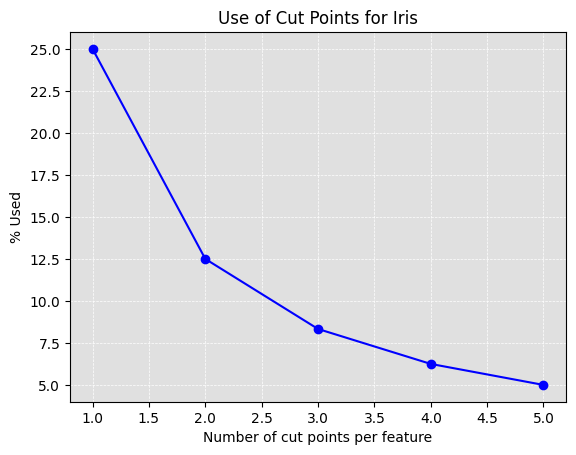

In [ ]:
import matplotlib.pyplot as plt
# Create x values from 1 to the number of elements in the list
x_values = list(range(1, len(perc_active_cut_list) + 1))

# Plotting the line graph
plt.plot(x_values,perc_active_cut_list, marker='o', linestyle='-', color='blue')

# Adding labels and title
plt.xlabel('Number of cut points per feature')
plt.ylabel('% Used')
plt.title('Use of Cut Points for Iris')

# Set background color and grid style
plt.gca().set_facecolor('#E0E0E0')  # Light gray background
plt.grid(color='white', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

##Dataset 5: Car Evaluation Dataset

Load data, extract features and labels, then split into train and test sets.

In [ ]:
# Load the Car Evaluation dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv(url, names=column_names)

# Encode categorical variables
categorical_features = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
one_hot_encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_features)
], remainder='passthrough')

X = one_hot_encoder.fit_transform(data.iloc[:, :-1])
y = pd.factorize(data['class'])[0]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Note: Scaling is not necessary for tree-based models and neural networks can be quite robust to unscaled data

###Decision Tree
Target to reproduce: 96.5%.

In [ ]:
# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate the model
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_car = round(dt_accuracy*100, 1)

print("Car Evaluation Decision Tree Accuracy:")
print("  Target:  ", 96.5)
print("  Achieved:", dt_car)

Car Evaluation Decision Tree Accuracy:
  Target:   96.5
  Achieved: 95.7


###Neural Network
Target to reproduce: 91.6%.

In [ ]:
# Neural Network Model using TensorFlow
def create_nn_model(input_shape, num_classes):
    model = Sequential([
        Dense(50, activation='relu', input_shape=input_shape),
        Dense(50, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Preparing the data
input_shape = (X_train.shape[1],)
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

nn_model_tf = create_nn_model(input_shape, num_classes)

# Training the model
nn_model_tf.fit(X_train, y_train_encoded, epochs=100, batch_size=10, verbose=0)

# Evaluating the model
nn_predictions_tf = nn_model_tf.predict(X_test)
nn_predictions_tf = [np.argmax(pred) for pred in nn_predictions_tf]
nn_accuracy_tf = accuracy_score(y_test, nn_predictions_tf)
nn_car = round(nn_accuracy_tf*100, 1)

print("Car Evaluation Neural Network Accuracy:")
print("  Target:  ", 91.6)
print("  Achieved:", nn_car)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Car Evaluation Neural Network Accuracy:
  Target:   91.6
  Achieved: 100.0


###Deep Neural Decision Tree
Target to reproduce: 95.1%.

In [ ]:
#DNDT .... Caution run with high ram and good gpu

sess = tf1.InteractiveSession()

# Load the Car Evaluation dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
car_data = pd.read_csv(url, names=column_names)

# Handle categorical features (convert them to numerical format)
# One-hot encode the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(car_data.drop('class', axis=1)).toarray()

# One-hot encode the target variable
y_encoded = pd.get_dummies(car_data['class']).values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Set random seeds for reproducibility
np.random.seed(1943)
tf1.set_random_seed(1943)

# Define placeholders for input and output
num_features = X_train.shape[1]
x_ph = tf1.placeholder(tf1.float32, [None, num_features])
y_ph = tf1.placeholder(tf1.float32, [None, 4])  # 4 classes in the target variable

# Define DNDT hyperparameters
num_cut = [1] * num_features  # Adjust as needed
num_classes = 4  # There are four classes in the Car Evaluation dataset

# Define variables for cut points and leaf scores
cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
num_leaf = np.prod(np.array(num_cut) + 1)
leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_classes]))

# Build the DNDT model
y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)

# Define loss and optimizer
loss = tf1.reduce_mean(tf1.nn.softmax_cross_entropy_with_logits_v2(labels=y_ph, logits=y_pred))
opt = tf1.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

# Initialize variables
sess.run(tf1.global_variables_initializer())

batch_size = 100  # Choose a batch size that fits your memory
num_batches = int(np.ceil(X_train.shape[0] / batch_size))

for i in range(1000):
    for batch in range(num_batches):
        batch_start = batch * batch_size
        batch_end = min(batch_start + batch_size, X_train.shape[0])
        X_batch = X_train[batch_start:batch_end]
        y_batch = y_train[batch_start:batch_end]
        _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_batch, y_ph: y_batch})
    if i % 100 == 0 and False:
        print("Loss at step {}: {:.4f}".format(i, loss_val))

# Evaluate the model
correct_prediction = tf1.equal(tf1.argmax(y_pred, 1), tf1.argmax(y_ph, 1))
accuracy = tf1.reduce_mean(tf1.cast(correct_prediction, tf1.float32))
test_accuracy = sess.run(accuracy, feed_dict={x_ph: X_test, y_ph: y_test})
dndt_car = round(test_accuracy*100, 1)

print("Car Evaluation Deep Neural Decision Tree Accuracy:")
print("  Target:  ", 95.1)
print("  Achieved:", dndt_car)

###Compare results from all models

In [ ]:
print("                    ", "DNDT", " DT ", " NN")
print("Target Accuracies:  ", 95.1, 96.5, 91.6)
print("Achieved Accuracies:", dndt_car, dt_car, nn_car)

                     DNDT  DT   NN
Target Accuracies:   95.1 96.5 91.6
Achieved Accuracies: 92.4 95.7 99.7


##Overall results from all datasets

In [ ]:
print("                                 ", "DNDT", " DT ", " NN")
print()
print("Haberman's Target:               ", 70.9, 66.1, 70.9)
print("Haberman's Achieved:             ", dndt_habermans, dt_habermans, nn_habermans)
print("Haberman's Similarity Coeff:     ", round(70.9/dndt_habermans, 2), round(66.1/dt_habermans,2), "", round(70.9/nn_habermans,1))
print()
print("Titanic Target:                  ", 80.4, 79.0, 76.9)
print("Titanic Achieved:                ", dndt_titanic, dt_titanic, nn_titanic)
print("Titanic Similarity Coeff:        ", round(80.4/dndt_titanic, 2), round(79.0/dt_titanic,2), "", round(76.9/nn_titanic,1))
print()
print("Pima Target:                     ", 66.9, 74.7, 64.9)
print("Pima Achieved:                   ", dndt_pima, dt_pima, nn_pima)
print("Pima Similarity Coeff:           ", round(66.9/dndt_pima, 2), round(74.7/dt_pima,2), "", round(64.9/nn_pima,1))
print()
print("Iris Target:                     ", 100.0, 100.0, 100.0)
print("Iris Achieved:                   ", dndt_iris, dt_iris, nn_iris)
print("Iris Similarity Coeff:           ", round(100.0/dndt_iris, 2),  " ", round(100.0/dt_iris,2), " ", round(100.0/nn_iris,1))
print()
print("Car Evaluation Target:           ", 95.1, 96.5, 91.6)
print("Car Evaluation Achieved:         ", dndt_car, dt_car, nn_car)
print("Car Evaluation Similarity Coeff: ", round(95.1/dndt_car, 2), round(96.5/dt_car,2), round(91.6/nn_car,1))

                                  DNDT  DT   NN

Haberman's Target:                70.9 66.1 70.9
Haberman's Achieved:              78.1 66.1 71.0
Haberman's Similarity Coeff:      0.91 1.0  1.0

Titanic Target:                   80.4 79.0 76.9
Titanic Achieved:                 75.3 79.2 80.9
Titanic Similarity Coeff:         1.07 1.0  1.0

Pima Target:                      66.9 74.7 64.9
Pima Achieved:                    65.6 74.7 74.0
Pima Similarity Coeff:            1.02 1.0  0.9

Iris Target:                      100.0 100.0 100.0
Iris Achieved:                    100.0 100.0 100.0
Iris Similarity Coeff:            1.0   1.0   1.0

Car Evaluation Target:            95.1 96.5 91.6
Car Evaluation Achieved:          92.4 95.7 100.0
Car Evaluation Similarity Coeff:  1.03 1.01 0.9


#Adjust DNDT Hyperparameters

Define function to create line graph.

In [ ]:
def show_graph(numbers, title, color):
  # Create a line graph
  plt.plot(numbers, color=color)

  # Add labels and title
  plt.xlabel('Number of Cut Points')
  plt.ylabel('Accuracy')
  plt.title(title)

  plt.xlim(1, len(numbers) - 1)

  # Display the graph
  plt.show()

##Dataset 1: Habermans

Load data, extract features and labels, then split into train and test sets.

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
data = pd.read_csv(url, header=None)

# Optionally, add column names for readability
data.columns = ['Age', 'Year', 'Nodes', 'Survival_Status']
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
accuracies_habermans = []
for i in range(1, 11):
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
  columns = ['Age', 'Year', 'Nodes', 'SurvivalStatus']
  data = pd.read_csv(url, header=None, names=columns)

  # The 'SurvivalStatus' column is '1' for patients who survived 5 years or longer and '2' for those who didn't.
  # Convert this to a binary classification problem: '0' for 'did not survive' and '1' for 'survived'
  data['SurvivalStatus'] = data['SurvivalStatus'].map({1: 0, 2: 1})

  # Separate features and target variable
  X = data.drop('SurvivalStatus', axis=1).values
  y = data['SurvivalStatus'].values

  # Normalize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Convert labels to one-hot encoding
  encoder = OneHotEncoder(sparse_output=False)
  y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

  np.random.seed(1943)
  tf1.set_random_seed(1943)

  d = X_scaled.shape[1]  # Number of features
  num_cut = [i, i, i]    # Number of cut points for each feature
  num_leaf = np.prod(np.array(num_cut) + 1)
  num_class = 2          # Binary classification

  sess = tf1.InteractiveSession()

  x_ph = tf1.placeholder(tf1.float32, [None, d])
  y_ph = tf1.placeholder(tf1.float32, [None, num_class])

  cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
  leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_class]))

  y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)
  loss = tf1.reduce_mean(tf1.losses.softmax_cross_entropy(logits=y_pred, onehot_labels=y_ph))
  opt = tf1.train.AdamOptimizer(0.1)
  train_step = opt.minimize(loss)

  sess.run(tf1.global_variables_initializer())

  for i in range(1000):
      _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_scaled, y_ph: y_one_hot})
      if i % 100 == 0 and False:
          print("Loss at step {}: {}".format(i, loss_val))

  accuracy = np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: X_scaled}), axis=1) == np.argmax(y_one_hot, axis=1))
  accuracies_habermans.append(round(accuracy, 2))

  sess.close()

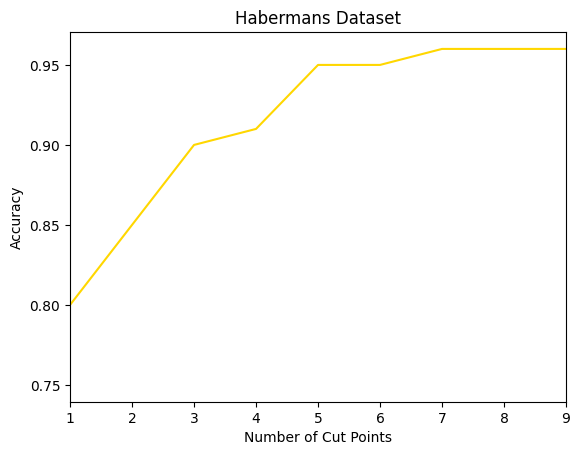

In [ ]:
show_graph(accuracies_habermans, 'Habermans Dataset', 'gold')

##Dataset 2: Pima

Load data, extract features and labels, then split into train and test sets.

In [ ]:
# Load the dataset from a public URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

# Separating features and target variable
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def nn_decision_tree(x, cut_points_list, leaf_score, temperature=0.1):
    # Ensure x is a 2D tensor
    if len(x.get_shape()) != 2:
        raise ValueError("Input x must be a 2D tensor")

    # Process each feature
    leaf = reduce(tf_kron_prod,
                  map(lambda z: tf_bin(tf1.reshape(x[:, z[0]:z[0] + 1], [-1, 1]), z[1], temperature),
                      enumerate(cut_points_list)))
    return tf1.matmul(leaf, leaf_score)

accuracies_pima = []
for i in range(1, 11):
  sess = tf1.InteractiveSession()

  # Load the Pima Indians Diabetes dataset
  url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
  column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
  pima_data = pd.read_csv(url, names=column_names)

  # Separate features and target variable
  X = pima_data.drop('Outcome', axis=1).values  # Assuming 'Outcome' is the target column
  y = pima_data['Outcome'].values

  # Normalize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

  # Set random seeds for reproducibility
  np.random.seed(1943)
  tf1.set_random_seed(1943)

  # Define placeholders for input and output
  num_features = X_train.shape[1]
  x_ph = tf1.placeholder(tf1.float32, [None, num_features])
  y_ph = tf1.placeholder(tf1.float32, [None])

  # Define DNDT hyperparameters
  num_cut = [1] * num_features  # Adjust as needed
  num_classes = 2  # Binary classification

  # Define variables for cut points and leaf scores
  cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
  num_leaf = np.prod(np.array(num_cut) + 1)
  leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_classes]))

  # Build the DNDT model (use the nn_decision_tree function from your original code)
  y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)

  # Define loss and optimizer
  loss = tf1.reduce_mean(tf1.losses.sparse_softmax_cross_entropy(labels=tf1.cast(y_ph, dtype=tf1.int32), logits=y_pred))
  opt = tf1.train.AdamOptimizer(0.1)
  train_step = opt.minimize(loss)

  # Initialize variables
  sess.run(tf1.global_variables_initializer())

  # Train the model
  for i in range(1000):
      _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_train, y_ph: y_train})
      if i % 100 == 0 and False:
          print("Loss at step {}: {:.4f}".format(i, loss_val))

  # Evaluate the model
  accuracy = tf1.reduce_mean(tf1.cast(tf1.equal(tf1.argmax(y_pred, 1), tf1.cast(y_ph, dtype=tf1.int64)), tf1.float32))
  test_accuracy = sess.run(accuracy, feed_dict={x_ph: X_test, y_ph: y_test})
  accuracies_pima.append(round(test_accuracy, 2))

  sess.close()

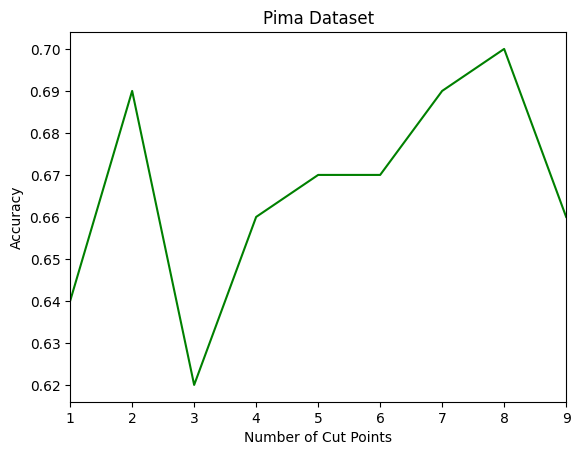

In [ ]:
show_graph(accuracies_pima, 'Pima Dataset', 'green')

## Dataset 3: Iris

Load data, extract features and labels, then split into train and test sets.

In [ ]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
accuracies_iris = []
for i in range(1, 11):
  sess = tf1.InteractiveSession()

  # Load the Iris dataset
  iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
  iris_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
  iris_data = pd.read_csv(iris_url, names=iris_columns)

  # Encode the 'species' column to integers
  label_encoder = LabelEncoder()
  iris_data['species'] = label_encoder.fit_transform(iris_data['species'])

  # Separate features and target variable
  X = iris_data.drop('species', axis=1).values
  y = iris_data['species'].values

  # Normalize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

  # Set random seeds for reproducibility
  np.random.seed(1943)
  tf1.set_random_seed(1943)

  # Define placeholders for input and output
  num_features = X_train.shape[1]
  x_ph = tf1.placeholder(tf1.float32, [None, num_features])
  y_ph = tf1.placeholder(tf1.int32, [None])

  # Define DNDT hyperparameters
  num_cut = [1] * num_features  # Adjust as needed
  num_classes = 3  # There are three classes in the Iris dataset

  # Define variables for cut points and leaf scores
  cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
  num_leaf = np.prod(np.array(num_cut) + 1)
  leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_classes]))

  # Build the DNDT model (use the nn_decision_tree function from your original code)
  y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)

  # Define loss and optimizer
  loss = tf1.reduce_mean(tf1.losses.sparse_softmax_cross_entropy(labels=y_ph, logits=y_pred))
  opt = tf1.train.AdamOptimizer(0.1)
  train_step = opt.minimize(loss)

  # Initialize variables
  sess.run(tf1.global_variables_initializer())

  # Train the model
  for i in range(1000):
      _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_train, y_ph: y_train})
      if i % 100 == 0 and False:
          print("Loss at step {}: {:.4f}".format(i, loss_val))

  # Evaluate the model
  accuracy = tf1.reduce_mean(tf1.cast(tf1.equal(tf1.argmax(y_pred, 1), tf1.cast(y_ph, tf1.int64)), tf1.float32))
  test_accuracy = sess.run(accuracy, feed_dict={x_ph: X_test, y_ph: y_test})
  accuracies_iris.append(round(test_accuracy, 2))

  sess.close()

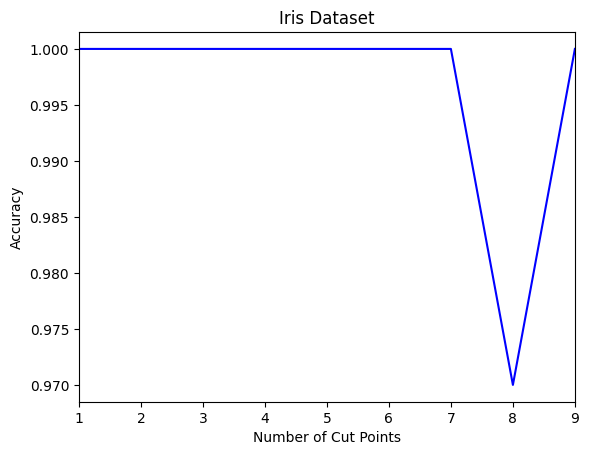

In [ ]:
show_graph(accuracies_iris, 'Iris Dataset', 'blue')

## Dataset 4: Car Evaluation

Load data, extract features and labels, then split into train and test sets.

In [ ]:
# Load the Car Evaluation dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv(url, names=column_names)

# Encode categorical variables
categorical_features = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
one_hot_encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_features)
], remainder='passthrough')

X = one_hot_encoder.fit_transform(data.iloc[:, :-1])
y = pd.factorize(data['class'])[0]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Note: Scaling is not necessary for tree-based models and neural networks can be quite robust to unscaled data

In [ ]:
#DNDT .... Caution run with high ram and good gpu
accuracies_car = []
for i in range(1, 11):
  sess = tf1.InteractiveSession()

  # Load the Car Evaluation dataset
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
  column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
  car_data = pd.read_csv(url, names=column_names)

  # Handle categorical features (convert them to numerical format)
  # One-hot encode the categorical features
  encoder = OneHotEncoder()
  X_encoded = encoder.fit_transform(car_data.drop('class', axis=1)).toarray()

  # One-hot encode the target variable
  y_encoded = pd.get_dummies(car_data['class']).values

  # Normalize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X_encoded)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

  # Set random seeds for reproducibility
  np.random.seed(1943)
  tf1.set_random_seed(1943)

  # Define placeholders for input and output
  num_features = X_train.shape[1]
  x_ph = tf1.placeholder(tf1.float32, [None, num_features])
  y_ph = tf1.placeholder(tf1.float32, [None, 4])  # 4 classes in the target variable

  # Define DNDT hyperparameters
  num_cut = [1] * num_features  # Adjust as needed
  num_classes = 4  # There are four classes in the Car Evaluation dataset

  # Define variables for cut points and leaf scores
  cut_points_list = [tf1.Variable(tf1.random_uniform([i])) for i in num_cut]
  num_leaf = np.prod(np.array(num_cut) + 1)
  leaf_score = tf1.Variable(tf1.random_uniform([num_leaf, num_classes]))

  # Build the DNDT model
  y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)

  # Define loss and optimizer
  loss = tf1.reduce_mean(tf1.nn.softmax_cross_entropy_with_logits_v2(labels=y_ph, logits=y_pred))
  opt = tf1.train.AdamOptimizer(0.1)
  train_step = opt.minimize(loss)

  # Initialize variables
  sess.run(tf1.global_variables_initializer())

  batch_size = 100  # Choose a batch size that fits your memory
  num_batches = int(np.ceil(X_train.shape[0] / batch_size))

  for i in range(1000):
      for batch in range(num_batches):
          batch_start = batch * batch_size
          batch_end = min(batch_start + batch_size, X_train.shape[0])
          X_batch = X_train[batch_start:batch_end]
          y_batch = y_train[batch_start:batch_end]
          _, loss_val = sess.run([train_step, loss], feed_dict={x_ph: X_batch, y_ph: y_batch})
      if i % 100 == 0 and False:
          print("Loss at step {}: {:.4f}".format(i, loss_val))

  # Evaluate the model
  correct_prediction = tf1.equal(tf1.argmax(y_pred, 1), tf1.argmax(y_ph, 1))
  accuracy = tf1.reduce_mean(tf1.cast(correct_prediction, tf1.float32))
  test_accuracy = sess.run(accuracy, feed_dict={x_ph: X_test, y_ph: y_test})
  accuracies_car.append(round(test_accuracy, 2))
  print("Test accuracy: {:.4f}".format(test_accuracy))

  sess.close()

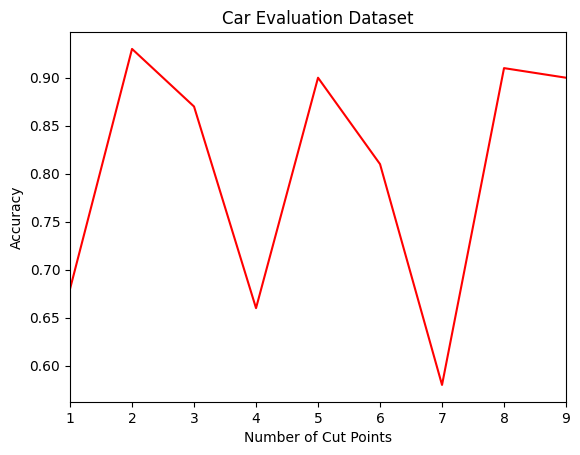

In [ ]:
show_graph(accuracies_car, "Car Evaluation Dataset", "red")